<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/Anomaly_detection_using_autoencoders_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras_preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pickle

In [2]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# minimize the data and reshape it to 128*128*1
a_file = open('/content/drive/MyDrive/Colab Notebooks/data_of_502_images(128).pkl', 'rb')
file_pic = pickle.load(a_file)

img_array = np.array(list(file_pic.values()))
img_array = img_array.astype('float32') / 255.
img_array = np.reshape(img_array, (len(img_array), 128, 128, 1))

x_train = img_array[:2000]
x_test = img_array[2000:]

In [4]:
# Size of input image
Size = 128

In [50]:
# Encoder
model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', padding='same', input_shape=(Size, Size, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

In [51]:
# training of model using mean squared error as a loss function
model.add(Conv2D(1, (3, 3), activation='linear', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

#Fit the model. 
history = model.fit(
        x_train, x_train,
        batch_size = 64,
        epochs=10,
        shuffle=True,
        validation_data=(x_test, x_test))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 24)      240       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 24)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        3472      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 8)       

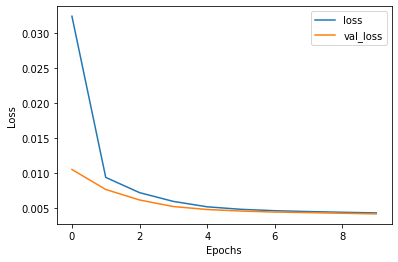

In [52]:
# train and val loss using mse
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [9]:
# caclulating reconstruction error for model trained using mse loss
reconstruction = model.predict(x_test)
test_loss = tf.keras.losses.mse(reconstruction, x_test)
# plt.hist(test_loss, bins=50)

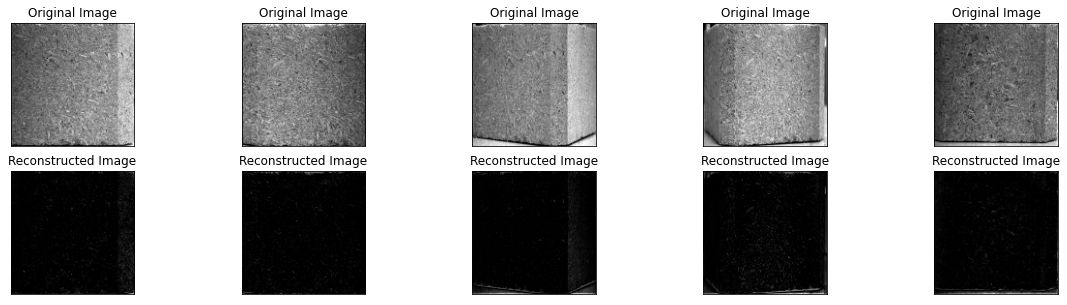

In [11]:
# first 5 orignal images and their reconstruction
n = 5
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(test_loss[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
plt.show()

In [13]:
## ssim loss function (for anomoaly images ssim loss value is large) / (Structural Similarity between two images in terms of luminance, contrast, and structure)
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [14]:
# training of model using SSIM loss
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer = 'adam', loss = SSIMLoss)
model.summary()

#Fit the model. 
history = model.fit(
        x_train, x_train,
        batch_size = 64,
        epochs=10,
        shuffle=True,
        validation_data=(x_test, x_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 24)      240       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 24)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        3472      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 8)       

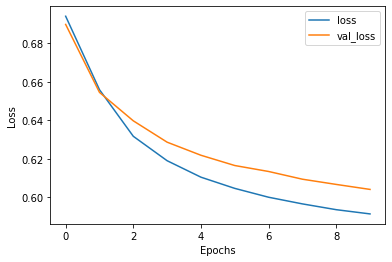

In [16]:
# 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [17]:
# store the train model into pickle file
# a_file = open("/content/drive/MyDrive/Colab Notebooks/model_with_simmloss_1.pkl", "wb")
# pickle.dump(model, a_file)
# a_file.close()

INFO:tensorflow:Assets written to: ram://ff772a60-4867-4191-9b8f-8c37ef82043d/assets


In [18]:
# predicting images
decoded_image = model.predict(x_test)

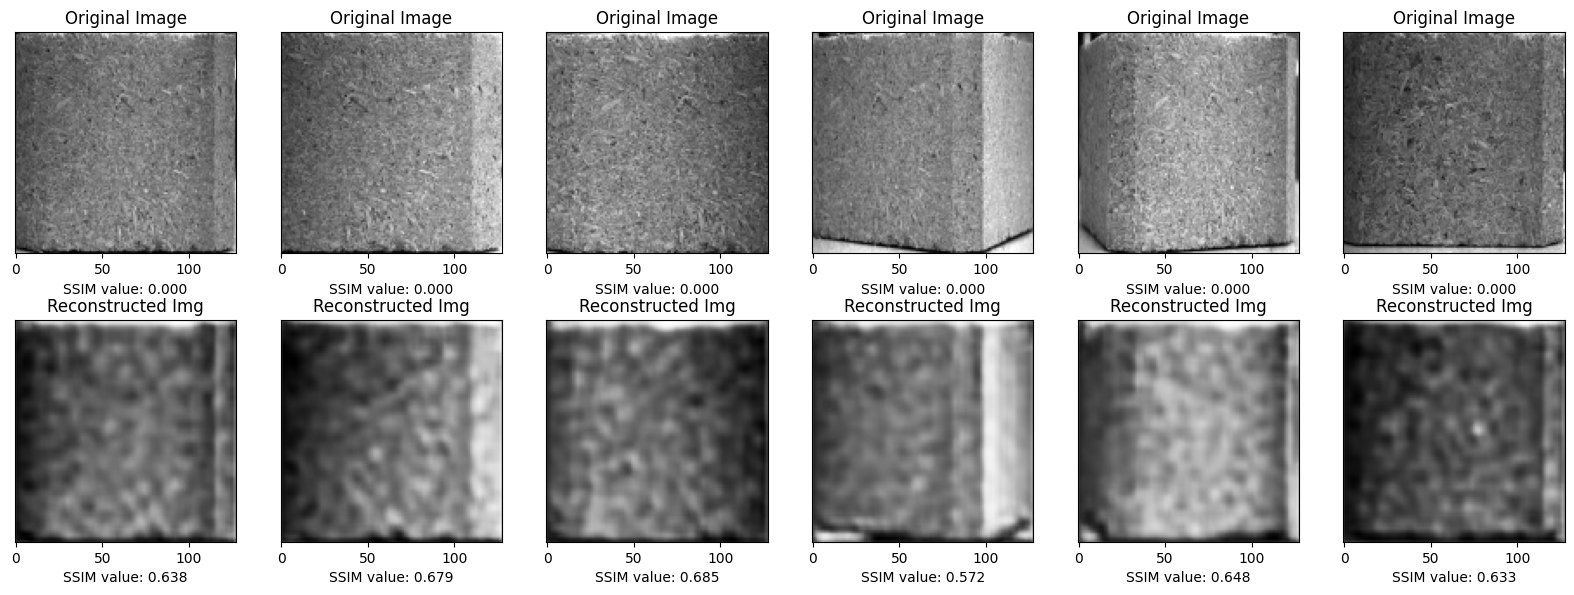

In [23]:
n = 6  # how many encoded and decoded images we will display
# decoded_imgs= autoencoder.predict(x_test)
plt.figure(figsize=(20, 7), dpi=100)
# plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(x_test[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test[i], x_test[i])
    ax.set_title("Original Image")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(decoded_image[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_image[i], x_test[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
plt.show()

In [24]:
## Five center images
center_imgs = []
center_imgs.append(file_pic[(401, 'C')])
center_imgs.append(file_pic[(402, 'C')])
center_imgs.append(file_pic[(403, 'C')])
center_imgs.append(file_pic[(404, 'C')])
center_imgs.append(file_pic[(405, 'C')])

center_imgs = np.array(center_imgs)

center_imgs = center_imgs.astype('float32') / 255.
center_imgs = np.reshape(center_imgs, (len(center_imgs), 128, 128, 1))
predicted_center_image = model.predict(center_imgs)

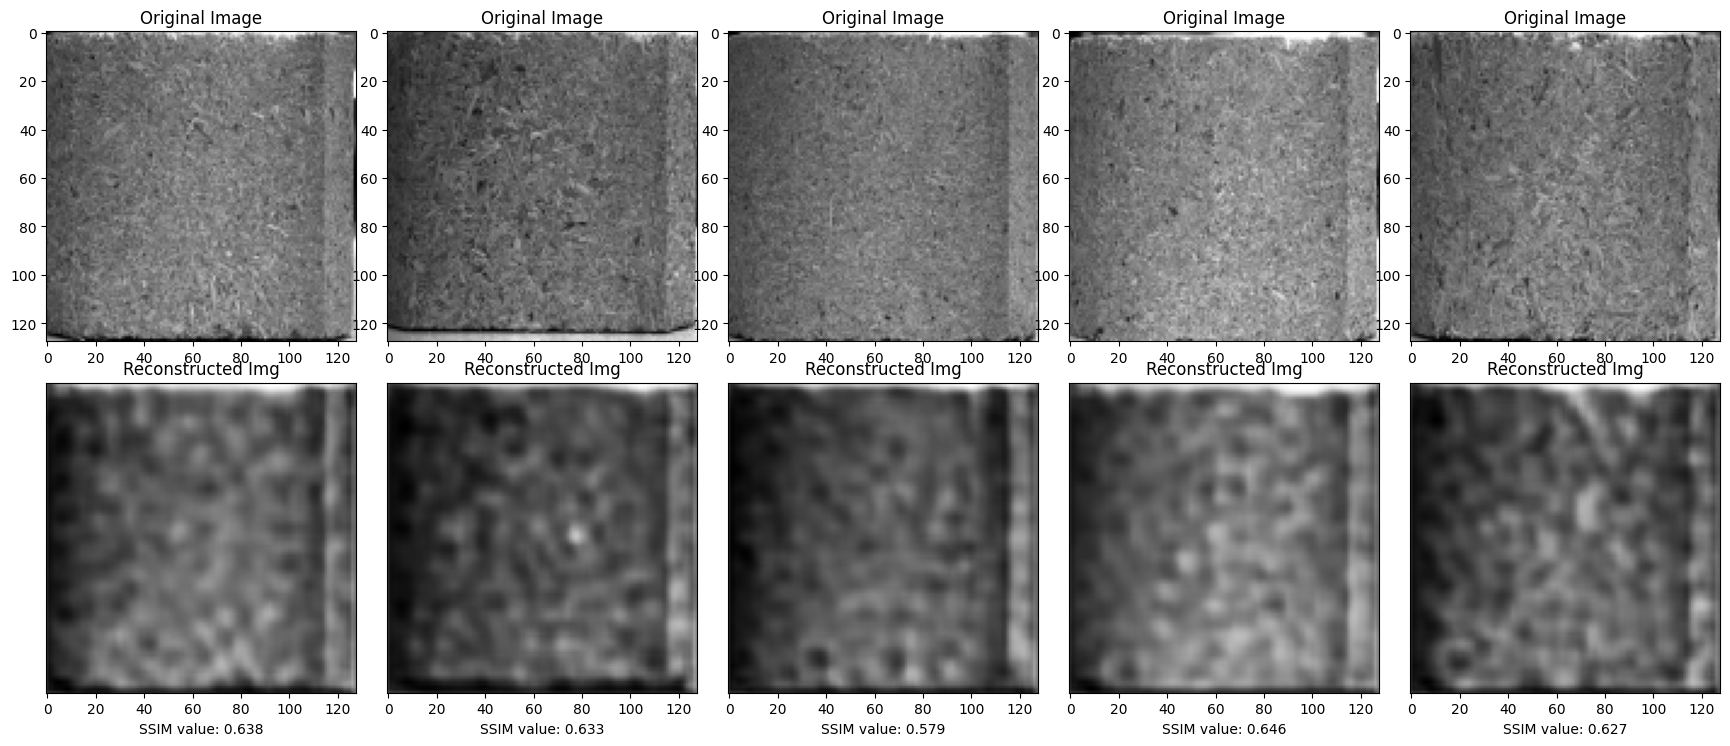

In [28]:
plt.figure(figsize=(26, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(center_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_center_image[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(center_imgs[i], predicted_center_image[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()

In [45]:
## comparing Five Left images
left_imgs = []
left_imgs.append(file_pic[(401, 'L')])
left_imgs.append(file_pic[(402, 'L')])
left_imgs.append(file_pic[(403, 'L')])
left_imgs.append(file_pic[(404, 'L')])
left_imgs.append(file_pic[(405, 'L')])

left_imgs = np.array(left_imgs)

left_imgs = left_imgs.astype('float32') / 255.
left_imgs = np.reshape(left_imgs, (len(left_imgs), 128, 128, 1))
predicted_left_imgs = model.predict(left_imgs)

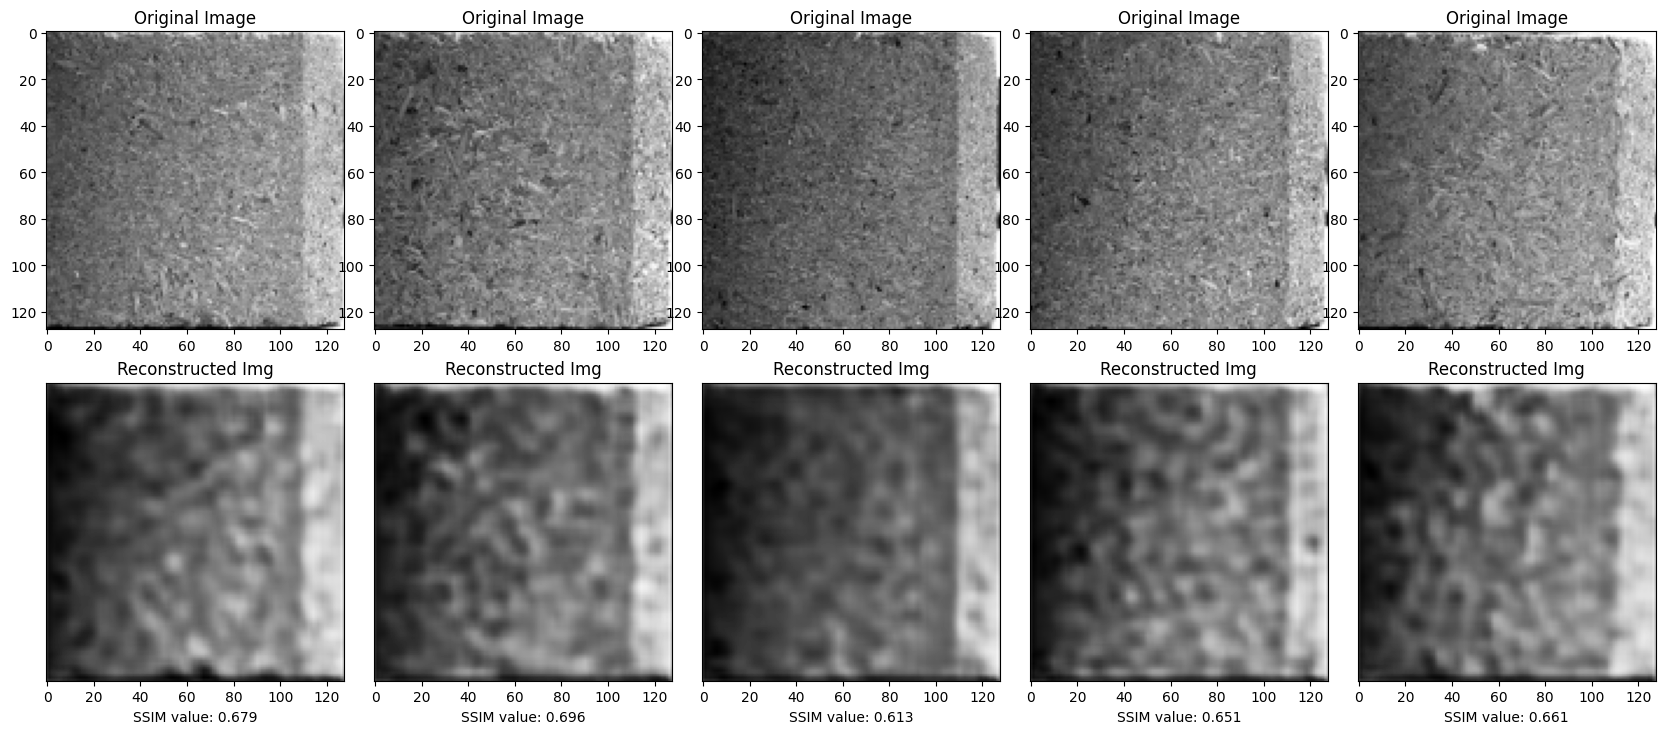

In [46]:
plt.figure(figsize=(25, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(left_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_left_imgs[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(left_imgs[i], predicted_left_imgs[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()

In [47]:
## comparing Five Right images
right_imgs = []
right_imgs.append(file_pic[(401, 'R')])
right_imgs.append(file_pic[(402, 'R')])
right_imgs.append(file_pic[(403, 'R')])
right_imgs.append(file_pic[(404, 'R')])
right_imgs.append(file_pic[(405, 'R')])

right_imgs = np.array(right_imgs)

right_imgs = right_imgs.astype('float32') / 255.
right_imgs = np.reshape(right_imgs, (len(right_imgs), 128, 128, 1))
predicted_right_imgs = model.predict(right_imgs)

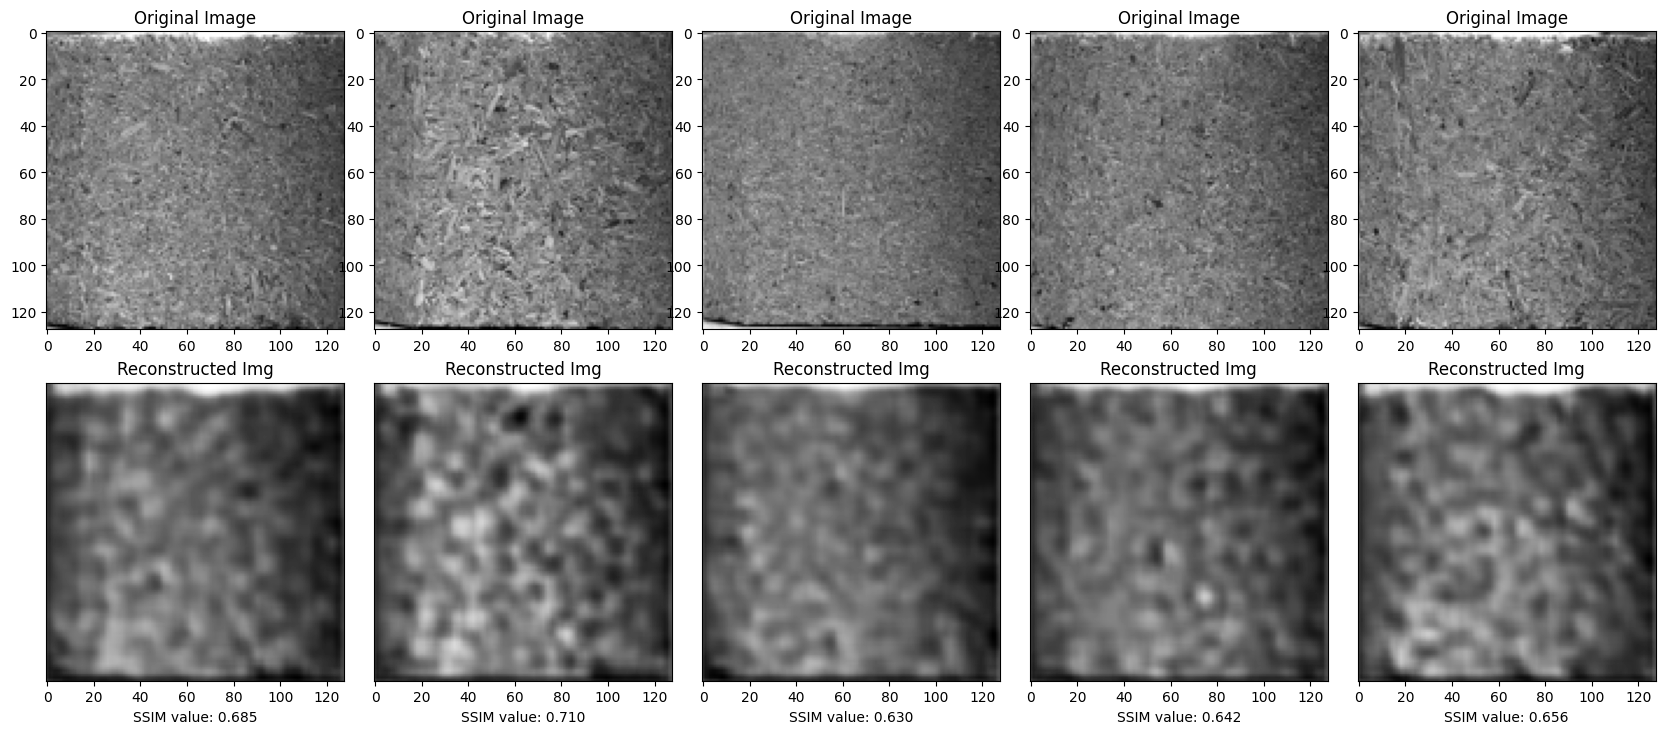

In [48]:
plt.figure(figsize=(25, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(right_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_right_imgs[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(right_imgs[i], predicted_right_imgs[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()

In [33]:
## comparing Five Right rotation images
right_rot_imgs = []
right_rot_imgs.append(file_pic[(401, 'RR')])
right_rot_imgs.append(file_pic[(402, 'RR')])
right_rot_imgs.append(file_pic[(403, 'RR')])
right_rot_imgs.append(file_pic[(404, 'RR')])
right_rot_imgs.append(file_pic[(405, 'RR')])

right_rot_imgs = np.array(right_rot_imgs)

right_rot_imgs = right_rot_imgs.astype('float32') / 255.
right_rot_imgs = np.reshape(right_rot_imgs, (len(right_rot_imgs), 128, 128, 1))
predicted_right_rot_imgs = model.predict(right_rot_imgs)

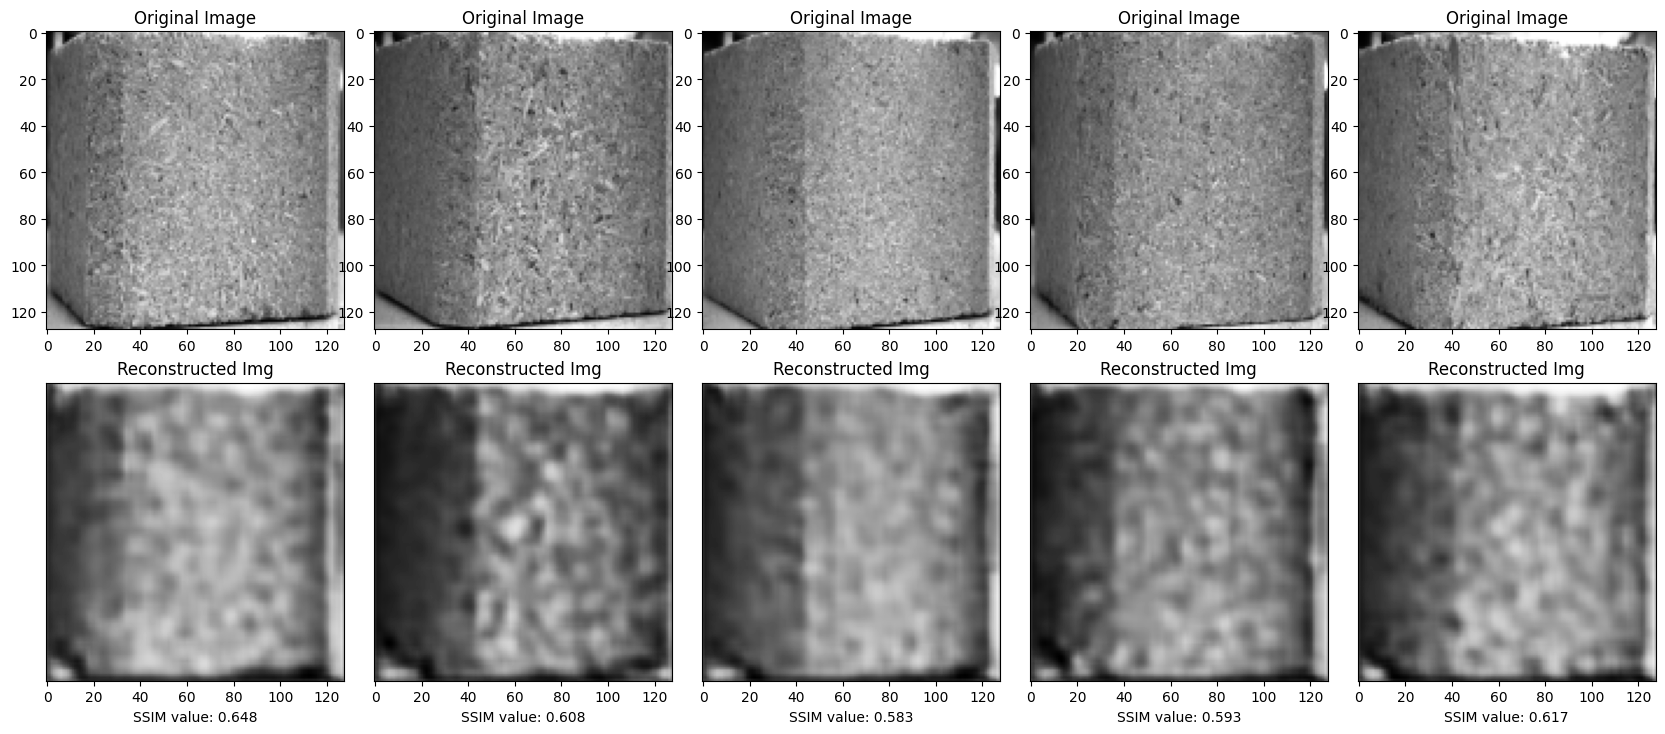

In [40]:
plt.figure(figsize=(25, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(right_rot_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_right_rot_imgs[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(right_rot_imgs[i], predicted_right_rot_imgs[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()

In [35]:
## comparing Five Right rotation images
left_rot_imgs = []
left_rot_imgs.append(file_pic[(401, 'RL')])
left_rot_imgs.append(file_pic[(402, 'RL')])
left_rot_imgs.append(file_pic[(403, 'RL')])
left_rot_imgs.append(file_pic[(404, 'RL')])
left_rot_imgs.append(file_pic[(405, 'RL')])

left_rot_imgs = np.array(left_rot_imgs)

left_rot_imgs = left_rot_imgs.astype('float32') / 255.
left_rot_imgs = np.reshape(left_rot_imgs, (len(left_rot_imgs), 128, 128, 1))
predicted_left_rot_imgs = model.predict(left_rot_imgs)

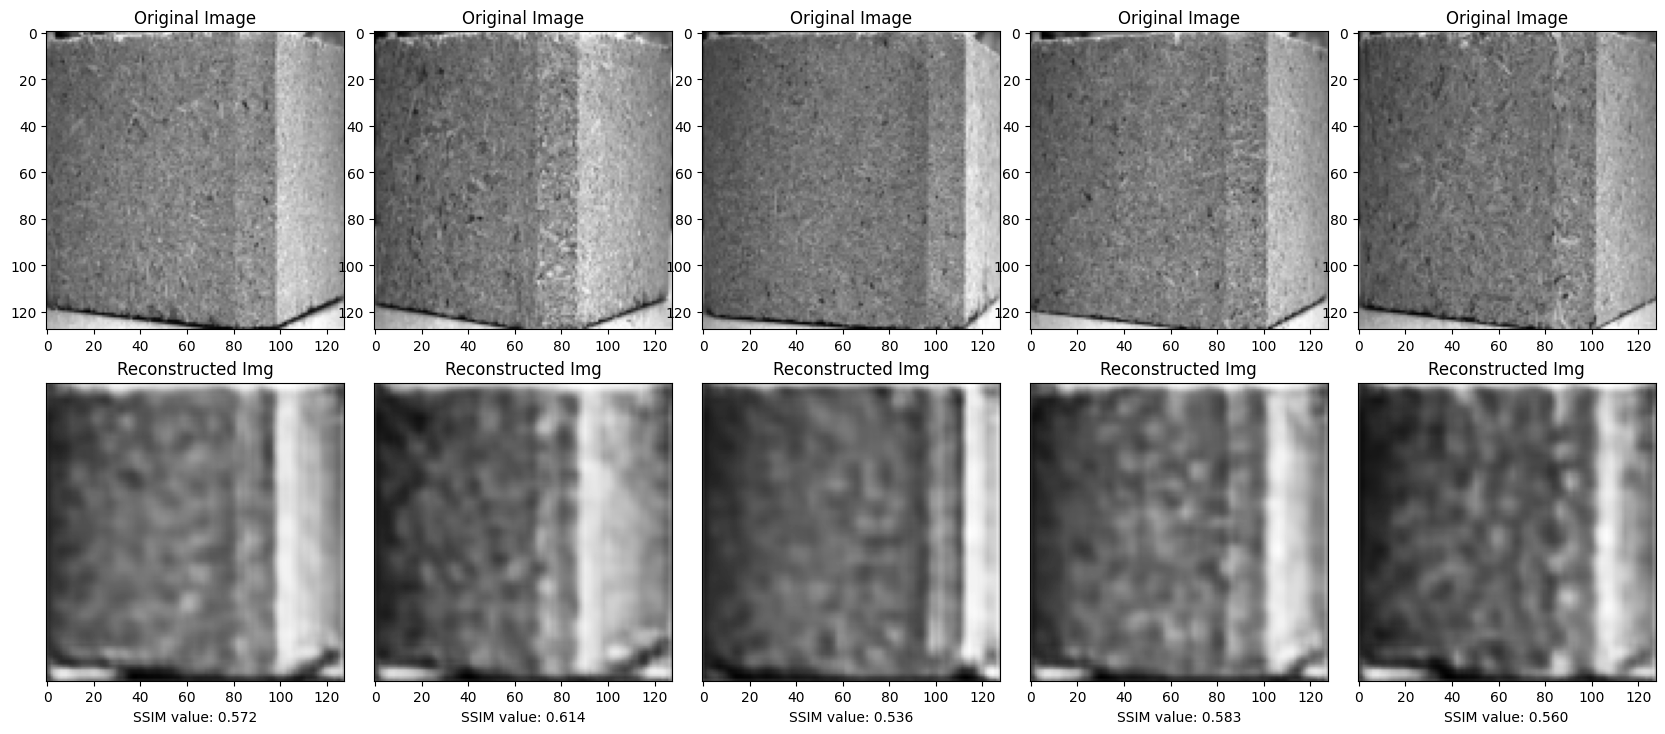

In [41]:
plt.figure(figsize=(25, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(left_rot_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_left_rot_imgs[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(left_rot_imgs[i], predicted_left_rot_imgs[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()

In [37]:
## comparing Five Right rotation images
all_cat_imgs = []
all_cat_imgs.append(file_pic[(406, 'C')])
all_cat_imgs.append(file_pic[(406, 'R')])
all_cat_imgs.append(file_pic[(406, 'L')])
all_cat_imgs.append(file_pic[(406, 'RL')])
all_cat_imgs.append(file_pic[(406, 'RR')])

all_cat_imgs = np.array(all_cat_imgs)

all_cat_imgs = all_cat_imgs.astype('float32') / 255.
all_cat_imgs = np.reshape(all_cat_imgs, (len(all_cat_imgs), 128, 128, 1))
predicted_all_cat_imgs = model.predict(all_cat_imgs)

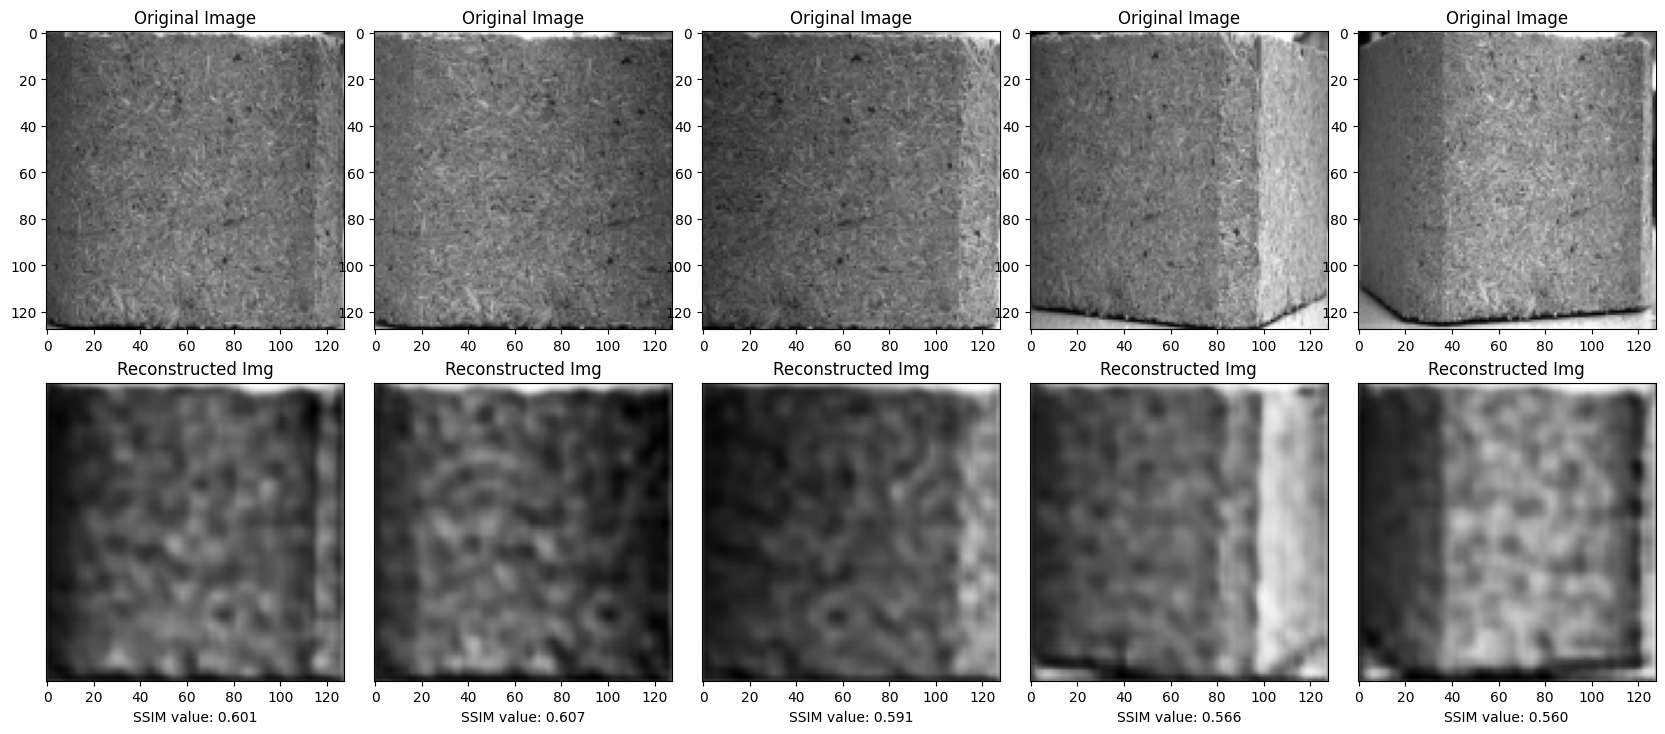

In [42]:
plt.figure(figsize=(25, 9), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(5):
    # Original Image
    ax = plt.subplot(2, n, plt_a + i  )
    plt.imshow(all_cat_imgs[i].reshape(128, 128))
    ax.set_title("Original Image")
    
    # Reconstructed Image  vs Original Image
    ax = plt.subplot(2, n, plt_a + i + n )
    plt.imshow(predicted_all_cat_imgs[i].reshape(128, 128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(all_cat_imgs[i], predicted_all_cat_imgs[i])
    ax.set_title("Reconstructed Img")
    label = 'SSIM value: {:.3f}'
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# plt.title('Center Images')
plt.show()